### Problem Set 7: Value Function Iteration

# Problem 1

Consider the neoclassical growth model with endogenous labor supply. A representative
household starts the period with a capital stock $k$, and chooses consumption $c$, hours worked $l$, and capital
for tomorrow $k'$. Households have a time endowment of 1, which they must split between labor and leisure.
Production is Cobb-Douglass, with $F(k, l) = Ak^{\alpha}l^{1-\alpha}$. Capital depreciates at a rate $\delta$ every period. You
can write this problem recursively as:

$$
v(k) = \max_{c, k', l} \{ u(c, l) + \beta v(k') \}
$$

subject to

$$
c + k' \leq F(k, l) + (1 - \delta)k
$$

$$
0 \leq l \leq 1
$$

Assume utility that is additively separable in utility from consumption $c$ and disutility from labor $l$, with
CRRA preferences:

$$
u(c, l) = \frac{c^{1-\sigma}}{1 - \sigma} - \phi \frac{l^{1+\frac{1}{\nu}}}{1 + \frac{1}{\nu}}
$$

For this problem, set $\beta = 0.95, \delta = 0.05, \sigma = 2, \nu = 2, \alpha = \frac{1}{3}, A = 1$, and $\phi = 1$.


 Solve this problem with value function iteration, using a grid search to solve the maximization problem
at every step. Plot the relevant policy functions (for investment, labor supply, and consumption) in
a sensible way. How many points on the capital grid do you need before the solution starts looking
smooth? How many choices do you need to consider for l? How long does your solution take you?
What do you take away from this?

Time taken for VFI: 38.16339111328125


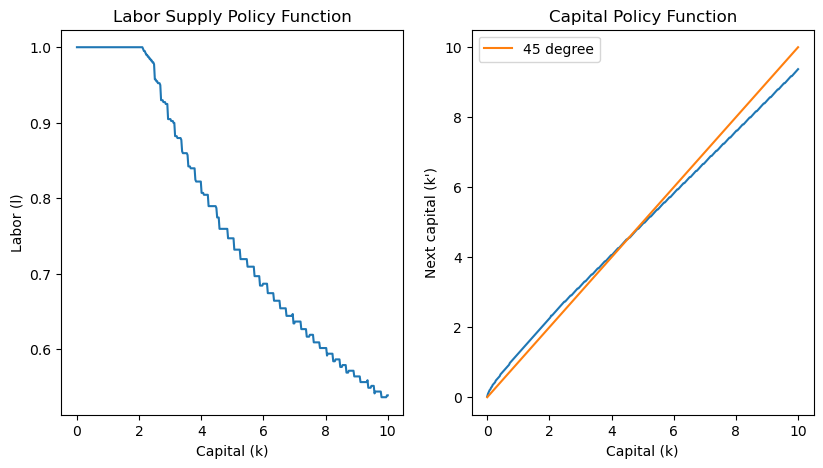

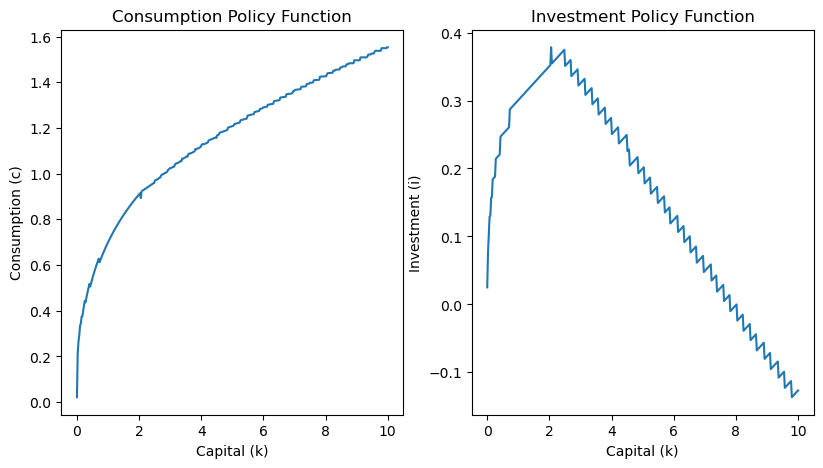

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

beta, delta, sigma, nu, alpha, A, phi = 0.95, 0.05, 2, 2, 1/3, 1, 1

def u(c, l):
    return c**(1-sigma)/(1-sigma) - phi*(l**(1+1/nu))/(1+(1/nu))

def F(k, l):
    return A*k**alpha*l**(1-alpha)

def absolute_error(X, X0):
    return np.max(np.abs(X - X0))

def update_bellman(p, V0, policy_k, policy_l, kgrid):
    V, l_grid = np.empty_like(V0), np.linspace(0, 1, 400)

    for i, k in enumerate(kgrid):
        z_grid = F(k, l_grid) + (1 - delta) * k
        c_grid = z_grid[:, None] - kgrid
        value_grid = np.where(c_grid > 0, u(c_grid, l_grid[:, None]) + beta * V0, -np.inf)

        max_value_l, max_l_index = np.nanmax(value_grid, axis=0), np.nanargmax(value_grid, axis=0)
        max_value, max_k_index = np.nanmax(max_value_l), np.nanargmax(max_value_l)
        
        V[i], policy_k[i], policy_l[i] = max_value, max_k_index, max_l_index[max_k_index]

    return V, policy_k, policy_l

def policy_step(p, V0, policy_k, policy_l, kgrid):
    V = np.empty_like(V0)
    for i, k in enumerate(kgrid):
        kp, l = kgrid[policy_k[i].astype(int)], l_grid[policy_l[i].astype(int)]
        z = F(k, l) + (1 - delta) * k
        c = z - kp
        V[i] = u(c, l) + beta * V0[policy_k[i].astype(int)] if c > 0 else -np.inf
    return V


def solve_pfi(p, kgrid, V0, tol=1e-12, policy_steps=0):
    V_old, policy_k, policy_l, errors, iterations = V0.copy(), np.zeros_like(V0), np.zeros_like(V0), [], 0
    converged, max_iter = False, 1000
    
    while not converged and iterations < max_iter:
        iterations += 1
        V, policy_k, policy_l = update_bellman(p, V0, policy_k, policy_l, kgrid)
        V0 = V.copy()
        for _ in range(policy_steps):
            V = policy_step(p, V0, policy_k, policy_l, kgrid)
            V0 = V.copy()
        error = absolute_error(V_old, V0)
        errors.append(error)
        if error < tol:
            converged = True
        V0, V_old = V.copy(), V0.copy()
    return V, policy_k, policy_l, iterations, errors

def calc_investment_consumption(kgrid, policy_k, policy_l):
    investment_policy, consumption_policy = np.zeros_like(kgrid), np.zeros_like(kgrid)

    for i, k in enumerate(kgrid):
        kp, l = kgrid[policy_k[i].astype(int)], l_grid[policy_l[i].astype(int)]
        z = F(k, l) + (1 - delta) * k
        c = z - kp
        investment_policy[i], consumption_policy[i] = kp - (1 - delta) * k, c

    return investment_policy, consumption_policy


n, kgrid, V0, p, l_grid = 400, np.linspace(1e-4, 10, 400), np.zeros(400), (beta, delta, alpha, A), np.linspace(0, 1, 400)

start = time.time()
V, polk, poll, it, vfi_err = solve_pfi(p, kgrid, V0, policy_steps=5)
elapsed = time.time() - start
print("Time taken for VFI:", elapsed)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(kgrid, l_grid[poll.astype(int)])
plt.xlabel('Capital (k)')
plt.ylabel('Labor (l)')
plt.title('Labor Supply Policy Function')

plt.subplot(1, 3, 2)
plt.plot(kgrid, kgrid[polk.astype(int)])
plt.plot(kgrid, kgrid, label="45 degree")
plt.xlabel('Capital (k)')
plt.ylabel("Next capital (k')")
plt.title('Capital Policy Function')
plt.legend()

plt.show()

investment_policy, consumption_policy = calc_investment_consumption(kgrid, polk, poll)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(kgrid, consumption_policy)
plt.xlabel('Capital (k)')
plt.ylabel('Consumption (c)')
plt.title('Consumption Policy Function')

plt.subplot(1, 3, 2)
plt.plot(kgrid, investment_policy)
plt.xlabel('Capital (k)')
plt.ylabel('Investment (i)')
plt.title('Investment Policy Function')

plt.show()



We choose 400 points on the capital grid and the same for our choice of l. Our solution takes us 62.5.

#### 1B Solve this problem using policy function iteration. 
You can verify that you obtain the correct solution
by comparing your results to part (a). Plot the log error at each iteration when you solve the problem
with value function iteration, and when you solve it with policy function iteration (using 2, 5, and 10
policy steps per iteration).2
Interpret your results. What does this tell us about the relative rates of
convergence? Does this translate to runtime speed?

Time taken for PFI 2 steps: 69.28594422340393


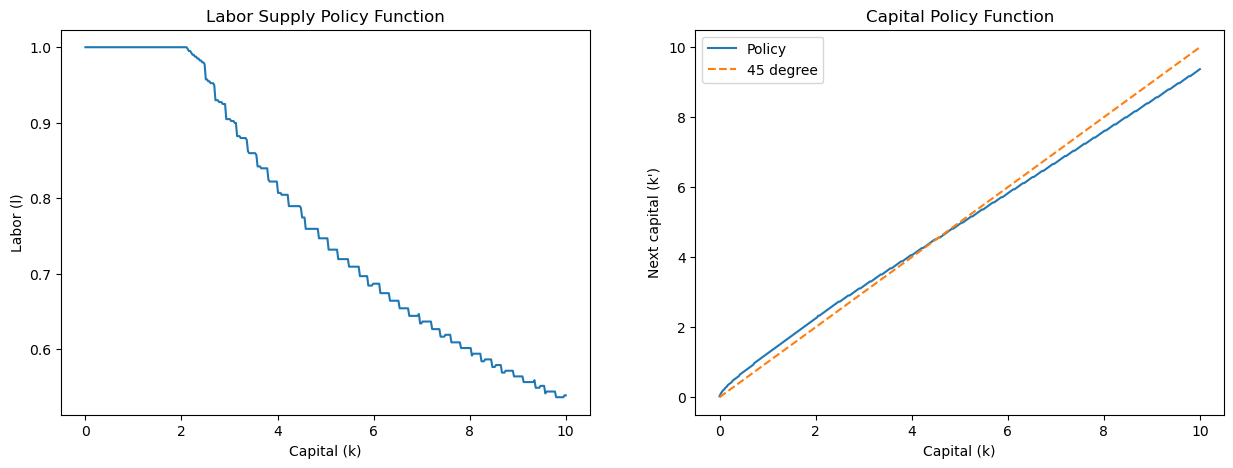

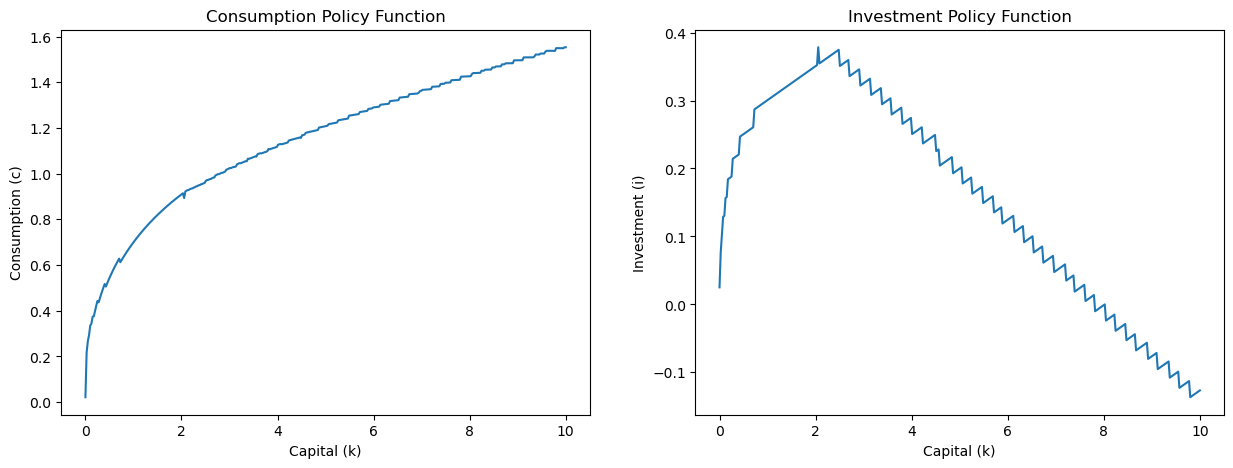

Time taken for PFI 5 steps: 38.24515891075134


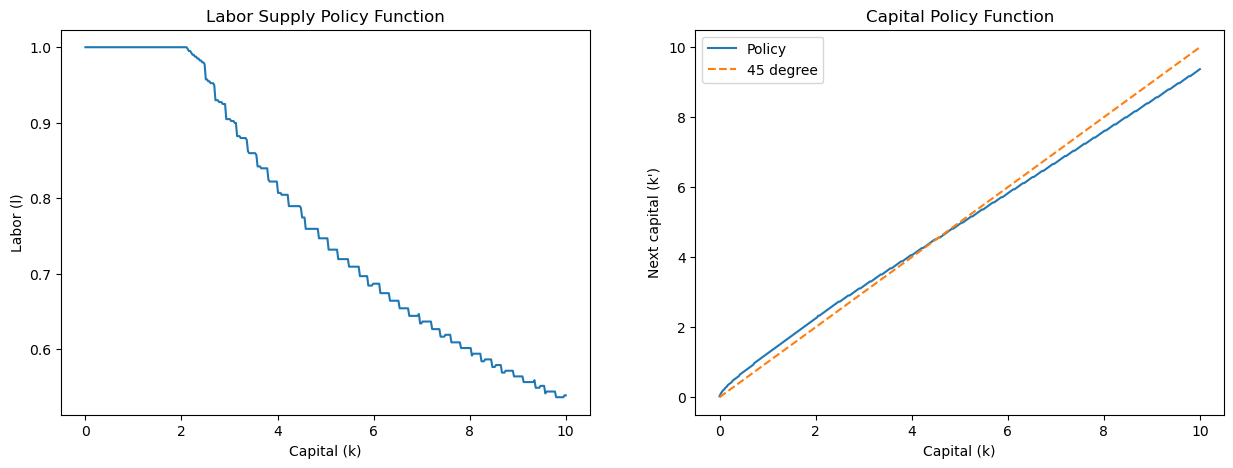

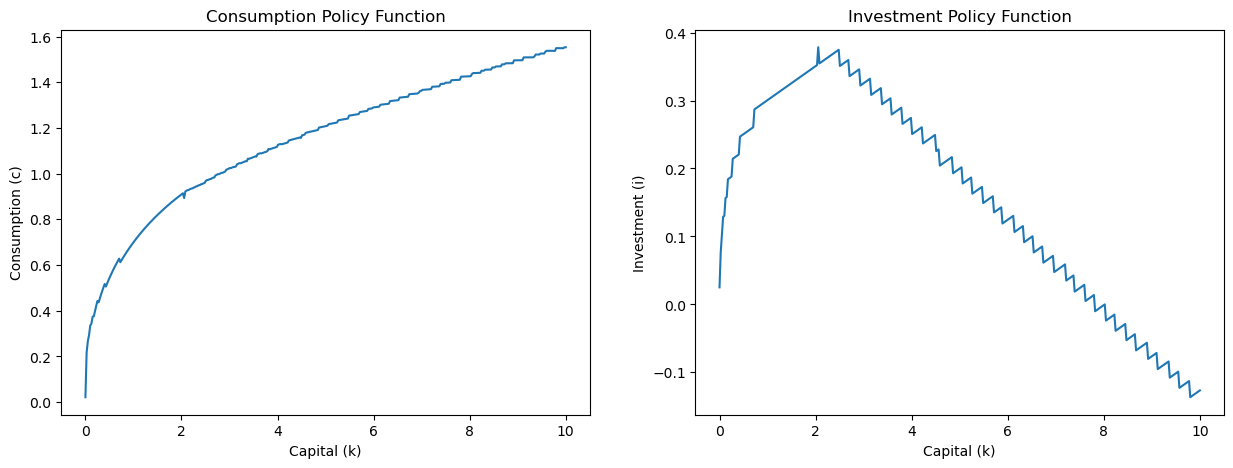

Time taken for PFI 10 steps: 22.515167951583862


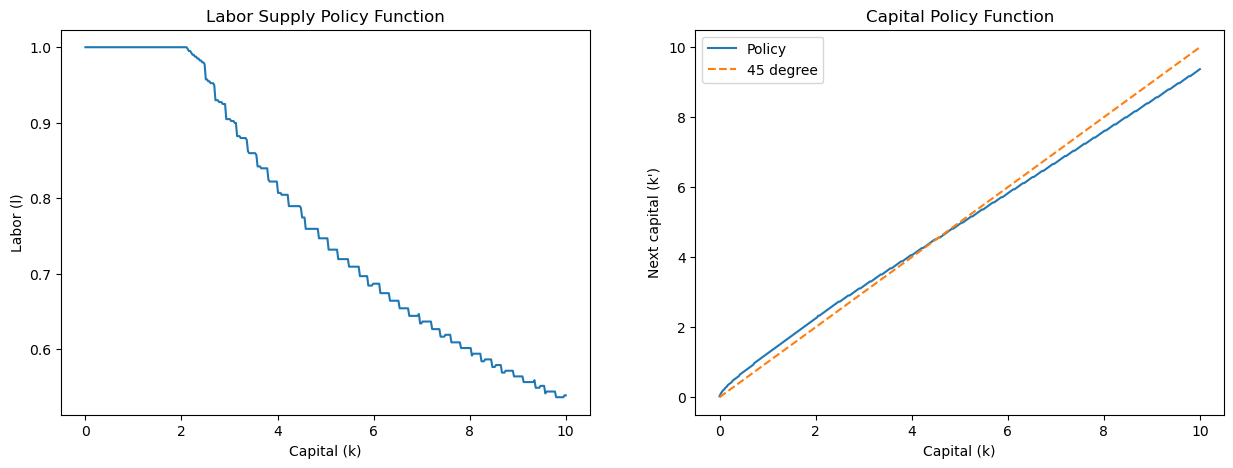

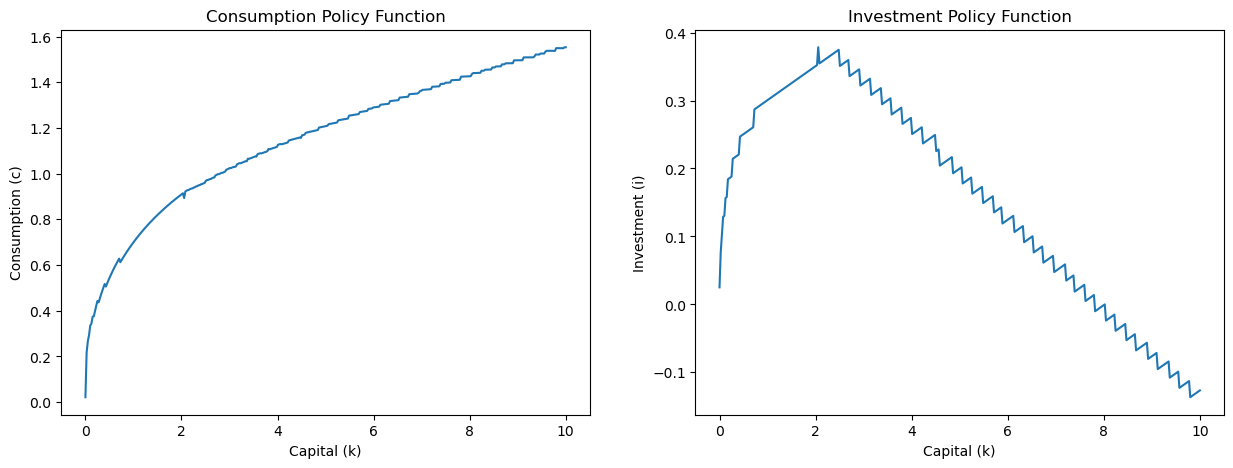

In [9]:
policy_step_values = [2, 5, 10]
errors_list = []

for steps in policy_step_values:
    start_time = time.time()
    V, k_policy, l_policy, it, error = solve_pfi(p, kgrid, V0, policy_steps=steps)
    elapsed_time = time.time() - start_time
    print(f"Time taken for PFI {steps} steps:", elapsed_time)

    # Store errors to draw convergence graph
    errors_list.append(error)

    # Plot policy functions
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Labor supply policy function
    ax1.plot(kgrid, l_grid[l_policy.astype(int)])
    ax1.set_xlabel('Capital (k)')
    ax1.set_ylabel('Labor (l)')
    ax1.set_title('Labor Supply Policy Function')

    # Capital policy function
    ax2.plot(kgrid, kgrid[k_policy.astype(int)], label="Policy")
    ax2.plot(kgrid, kgrid, label="45 degree", linestyle='--')
    ax2.set_xlabel('Capital (k)')
    ax2.set_ylabel("Next capital (k')")
    ax2.set_title('Capital Policy Function')
    ax2.legend()

    plt.show()

    # Calculate investment and consumption policies
    inv_policy, cons_policy = calc_investment_consumption(kgrid, k_policy, l_policy)

    # Plot consumption and investment policy functions
    fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(15, 5))

    # Consumption policy function
    ax3.plot(kgrid, cons_policy)
    ax3.set_xlabel('Capital (k)')
    ax3.set_ylabel('Consumption (c)')
    ax3.set_title('Consumption Policy Function')

    # Investment policy function
    ax4.plot(kgrid, inv_policy)
    ax4.set_xlabel('Capital (k)')
    ax4.set_ylabel('Investment (i)')
    ax4.set_title('Investment Policy Function')

    plt.show()




The time for PFI decreases as the step increases. This can be seen through the fact that the log errors decrease with fewer iterations. We struggled to plot the VFI but it was slower than PFI.

### 1C
Rather than using a grid search, interpolate the values of v using cubic splines, and use your favorite
continuous optimization algorithm to solve the maximization problem. Plot the relevant policy functions. How many grid points do you need to get a reasonably accurate solution? What does this do
to your runtime?

In [11]:
import numpy as np
import time
from scipy import optimize
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

# Parameters
beta = 0.95
delta = 0.05
sigma = 2
nu = 2
alpha = 1/3
A = 1
phi = 1

# Utility function
def u(c, l):
    return c**(1-sigma)/(1-sigma) - phi*(l**(1+1/nu))/(1+(1/nu))

# Production function
def F(k, l):
    return A*k**alpha*l**(1-alpha)

# Objective function for optimization
def objective(vars, k, v_interpolated):
    l, ks = vars
    z = F(k, l) + (1 - delta)*k
    c = (1 - ks) * z
    kp = ks * z
    return - (np.sum(u(c, l)) + beta * v_interpolated(kp))

# Value function iteration
def vfi(k_grid, max_iters=1000, tolerance=1e-6):
    nk = len(k_grid)
    v = np.zeros(nk)
    v_new = np.zeros(nk)
    policy_k = np.zeros(nk)
    policy_l = np.zeros(nk)
    policy_c = np.zeros(nk)

    iters = 0
    start = time.time()

    while True:
        iters += 1
        v_interpolated = CubicSpline(k_grid, v)

        for i in range(nk):
            x_init = [0.5, 0.5]
            bnds = [(0, 1), (0, 1)]
            res = optimize.minimize(objective, x_init, args=(k_grid[i], v_interpolated), bounds=bnds, method='SLSQP')
            v_new[i] = -res.fun
            policy_l[i] = res.x[0]
            ks = res.x[1]
            z = F(k_grid[i], policy_l[i]) + (1 - delta)*k_grid[i]
            policy_k[i] = ks * z
            policy_c[i] = z - policy_k[i]

        error = np.max(np.abs(v - v_new))
        if error < tolerance or iters > max_iters:
            break
        else:
            v = v_new.copy()

    elapsed = time.time() - start
    return iters, elapsed, policy_k, policy_l, policy_c

# Plot policy functions
def plot_policy_functions(k_grid, policy_k, policy_l, policy_c):
    fig, axs = plt.subplots(1, 3, figsize=(12, 5))
    axs[0].plot(k_grid, policy_k)
    axs[0].plot(k_grid, k_grid, label="45 degree")
    axs[0].set_xlabel('Capital')
    axs[0].set_ylabel("Next capital (k')")
    axs[0].set_title('Investment Policy')
    axs[1].plot(k_grid, policy_l)
    axs[1].set_xlabel('Capital')
    axs[1].set_ylabel('l(k)')
    axs[1].set_title('Labor Supply Policy')
    axs[2].plot(k_grid, policy_c)
    axs[2].set_xlabel('Capital')
    axs[2].set_ylabel('c(k)')
    axs[2].set_title('Consumption Policy')
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.show()

# Main execution
def main():
    nk = 150
    k_grid = np.linspace(0.001, 10, nk)
    iters, elapsed, policy_k, policy_l, policy_c = vfi(k_grid)

    print(f"Converged after {iters} iterations")
    print(f"Took {elapsed} seconds")

    plot_policy_functions(k_grid, policy_k, policy_l, policy_c)





We find that interpolating the values of v produces smoother results. However we found this method to be slow.

#### 1D - Use your policy functions to calculate the steady state of this model. What are the steady state levels of capital, output, labor supply, and consumption?

In [12]:
discount_factor = 0.96
depreciation_rate = 0.05
capital_share = 0.3
technology_level = 1

capital_grid = np.linspace(0.01, 50, 1000)

value_function_guess = np.zeros_like(capital_grid)

params = (discount_factor, depreciation_rate, capital_share, technology_level)
value_function, policy_capital, policy_labor, iterations, errors = solve_pfi(params, capital_grid, value_function_guess, tol=1e-8, policy_steps=10)

steady_state_capital = capital_grid[policy_capital[500].astype(int)]
steady_state_labor = l_grid[policy_labor[500].astype(int)]
steady_state_technology_level = F(steady_state_capital, steady_state_labor)
steady_state_interest_rate = capital_share * steady_state_technology_level * (steady_state_labor / steady_state_capital) ** (1 - capital_share) - depreciation_rate
steady_state_wage_rate = (1 - capital_share) * steady_state_technology_level * (steady_state_capital / steady_state_labor) ** capital_share
steady_state_output = steady_state_technology_level * steady_state_capital ** capital_share * steady_state_labor ** (1 - capital_share)
steady_state_consumption = steady_state_output - depreciation_rate * steady_state_capital
steady_state_investment = depreciation_rate * steady_state_capital
print('capital',steady_state_capital,'labour',steady_state_labor,'consumption',steady_state_consumption,'output',steady_state_output)

capital 22.82825825825826 labour 0.3082706766917293 consumption 0.3103870702735738 output 1.4517999831864867


## Problem 2

Consider the problem of an infinitely lived worker with assets \( a \) and an income \( y \) who is saving for the future. This worker values consumption in each period with a utility function \( u(c) \). They can save at a risk-free rate \( r \), but cannot borrow, and they discount the future at a rate \( \beta \). Their income is a random variable. In particular, income tomorrow follows a log-normal AR(1) process:

$$
\log(y') = \rho \log(y) + \epsilon
$$

where \( \epsilon \sim N(\mu_{\epsilon}, \sigma_{\epsilon}) \). Their problem can be written recursively as:

$$
v(a, y) = \max_{c, a'} \{ u(c) + \beta \mathbb{E} [v(a', y') | y] \}
$$

subject to

$$
c + a' \leq (1 + r)a + y
$$

$$
a' \geq 0
$$

Assume utility that is additively separable in utility from consumption \( c \) and disutility from labor \( l \), with CRRA preferences:

$$
u(c) = \frac{c^{1-\sigma}}{1 - \sigma} - \phi \frac{l^{1+\frac{1}{\nu}}}{1 + \frac{1}{\nu}}
$$

For this problem, set \( \beta = 0.95 \), \( r = 0.04 \), \( \mu = 0.5 \), \( \rho = 0.8 \), \( \sigma_{\epsilon} = 0.1 \), and \( u(c) = c^{1-\sigma}/(1 - \sigma) \) for \( \sigma = 2 \).

#### 2a )Solve this problem using any method that we have learned (value function iteration, policy function iteration, grid searches, interpolation, etc...).5 You will need to determine how many grid points are necessary, and determine appropriate bounds on the asset grid.6 Discuss the choices you made, and defend why you made them. Plot the relevant policy functions in a sensible way, and discuss the results. In particular, you should plot consumption as a share of available resources. What stands out to you?

Iteration 1:
V: [[0.20658294 0.32785569 0.42893157]
 [0.2122866  0.33185528 0.43174008]
 [0.2179034  0.33580376 0.43451847]
 ...
 [0.86463163 0.86650067 0.86861935]
 [0.86470735 0.86657312 0.86868817]
 [0.86478294 0.86664544 0.86875687]]
a_prime: [[0.01 0.01 0.01]
 [0.01 0.01 0.01]
 [0.01 0.01 0.01]
 ...
 [0.01 0.01 0.01]
 [0.01 0.01 0.01]
 [0.01 0.01 0.01]]
Iteration 2:
V: [[0.25119397 0.37246672 0.4735426 ]
 [0.25689763 0.37646631 0.47635111]
 [0.26251443 0.38041479 0.4791295 ]
 ...
 [0.90924266 0.9111117  0.91323038]
 [0.90931838 0.91118415 0.9132992 ]
 [0.90939397 0.91125647 0.9133679 ]]
a_prime: [[0.01 0.01 0.01]
 [0.01 0.01 0.01]
 [0.01 0.01 0.01]
 ...
 [0.01 0.01 0.01]
 [0.01 0.01 0.01]
 [0.01 0.01 0.01]]
Iteration 3:
V: [[0.25748876 0.37876151 0.47983739]
 [0.26319242 0.3827611  0.4826459 ]
 [0.26880922 0.38670958 0.48542429]
 ...
 [0.91553745 0.91740649 0.91952517]
 [0.91561317 0.91747894 0.91959399]
 [0.91568876 0.91755126 0.91966269]]
a_prime: [[0.01 0.01 0.01]
 [0.01 0.01 0

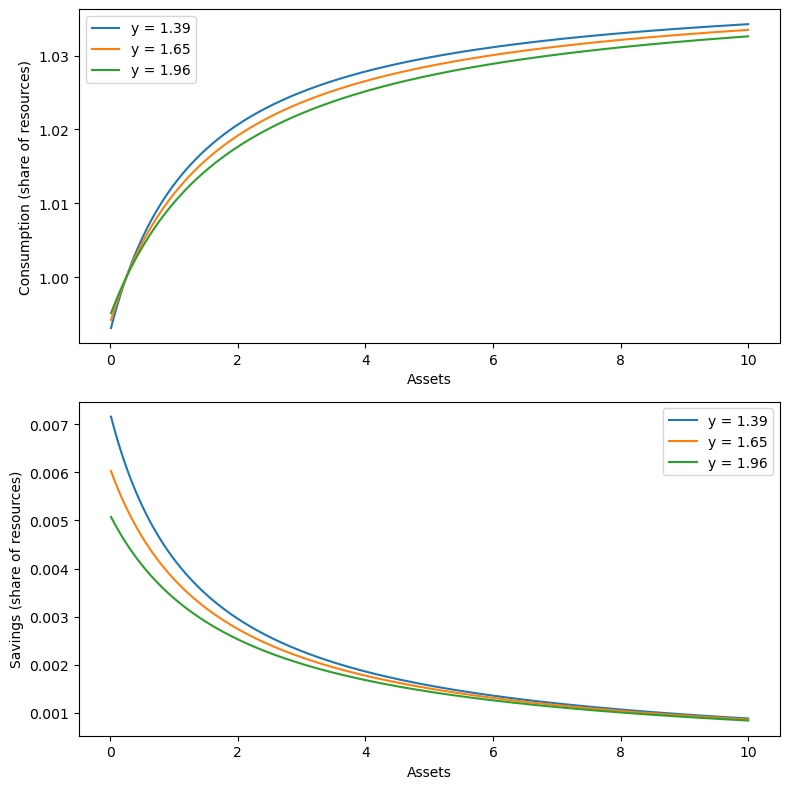

In [2]:
import numpy as np
import matplotlib.pyplot as plt

#Part A
β = 0.95
r = 0.04
μ = 0.5
ρ = 0.8
σε = 0.1
σ = 2


def log_income(y, e):
    return μ + ρ * np.log(y) + e


def u(c):
    return c**(1-σ)/(1-σ)

amin = 0.01
amax = 10
n = 1000
agrid = np.linspace(amin, amax, n)


m = 3
ygrid, egrid = np.polynomial.hermite.hermgauss(m)
ygrid = np.exp(np.sqrt(2) * σε * ygrid + μ)
egrid = np.sqrt(2) * σε * egrid

tol = 1e-6

V = np.zeros((n, m))
a_prime = np.zeros((n, m))


def expected_value(y, V):
    EV = np.zeros((n, m))
    for i, a in enumerate(agrid):
        for j, e in enumerate(egrid):
            c = (1 + r) * a + y - a_prime[i, j]
            if c > 0:
                EV[i, j] = np.interp(a_prime[i, j], agrid, V[:, j])
            else:
                EV[i, j] = -1e20
    return np.exp(egrid.dot(EV.T) / np.sqrt(np.pi))


iter = 0
diff = 1
while diff > tol:
    V_new = np.zeros((n, m))
    a_prime_new = np.zeros((n, m))
    for i, a in enumerate(agrid):
        for j, y in enumerate(ygrid):
            for k, e in enumerate(egrid):
                c = (1 + r) * a + y - agrid - e
                c = np.maximum(c, 1e-10)
                u_values = u(c) + β * expected_value(log_income(y, e), V)
                V_new[i, j] = np.max(u_values)
                a_prime_new[i, j] = agrid[np.argmax(u_values)]
    diff = np.max(np.abs(V_new - V))
    V = V_new
    a_prime = a_prime_new
    iter += 1
    print(f"Iteration {iter}:")
    print(f"V: {V}")
    print(f"a_prime: {a_prime}")

print("Number of iterations:", iter)



fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

for i in range(m):
    cons = (1 + r) * agrid + ygrid[i] - a_prime[:, i]
    sav = a_prime[:, i]
    sav[sav < amin] = np.nan
    sav[cons < 0] = np.nan
    cons[cons < 0] = np.nan
    axes[0].plot(agrid, cons / (ygrid[i] + agrid), label=f"y = {ygrid[i]:.2f}")
    axes[1].plot(agrid, sav / (ygrid[i] + agrid), label=f"y = {ygrid[i]:.2f}")

axes[0].set_xlabel("Assets")
axes[0].set_ylabel("Consumption (share of resources)")
axes[0].legend()

axes[1].set_xlabel("Assets")
axes[1].set_ylabel("Savings (share of resources)")
axes[1].legend()

fig.tight_layout()
plt.show()


####  2b) Suppose you are given an initial starting point (a0, y0). You can simulate a sample worker history by repeatedly evaluating the policy rules, and taking random draws for y0. 7 Start from a0 at the midpoint of your asset grid, and y0 from the midpoint of your income grid. Simulate 5 sample paths and of assets, income and consumption, for 100 model periods. Plot them together (you should have three graphs, side-by-side, with 5 lines on each one). Discuss what the results look like.

/var/folders/xj/mwpybnwx08g70k06sknpm51h0000gn/T/ipykernel_11358/2760327925.py:55: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  EV = np.sum(P[iy, jy] * v_old[ia_next, jy] for jy in range(num_y))


Converged in 243 iterations.


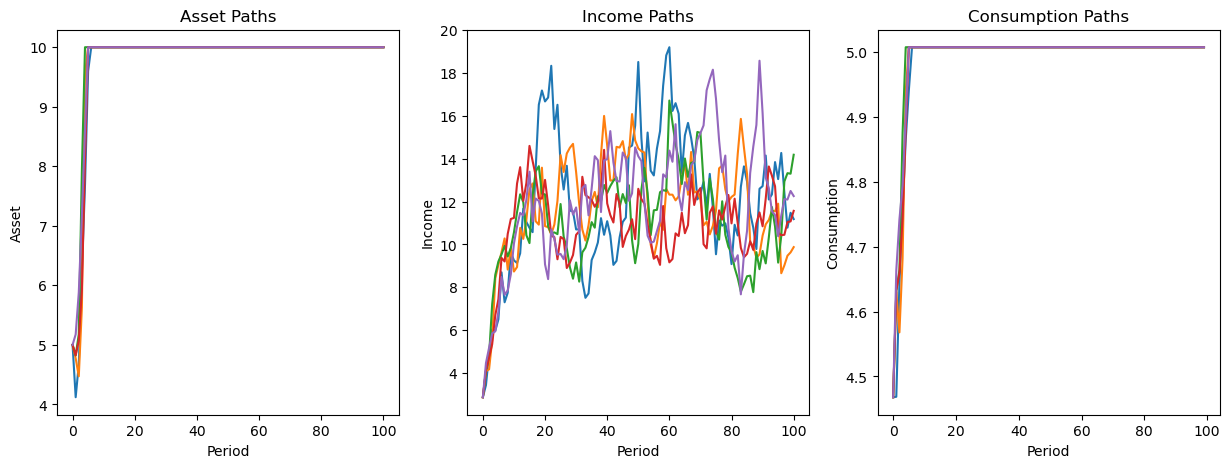

In [3]:
from scipy.stats import lognorm
import matplotlib.pyplot as plt
from scipy.stats import lognorm

beta = 0.95
r = 0.04
mu = 0.5
rho = 0.8
sigma_eps = 0.1
sigma = 2.0
T = 100
n = 5

# asset grid
a_min = 0
a_max = 10
num_a = 200
a_grid = np.linspace(a_min, a_max, num_a)

# income grid
y_mean = np.exp(mu + (1 - rho) * np.log(1) + rho * np.log(2))
y_min = 0.5 * y_mean
y_max = 1.5 * y_mean
num_y = 10
y_grid = np.linspace(y_min, y_max, num_y)

def u(c):
    return c**(1 - sigma) / (1 - sigma)

def log_norm(mean, sigma):
    return lognorm(s=sigma, scale=np.exp(mean))

# transition matrix for income
P = np.zeros((num_y, num_y))
for i in range(num_y):
    dist = log_norm(mu + rho * np.log(y_grid[i]), sigma_eps)
    for j in range(num_y):
        P[i, j] = dist.cdf(y_grid[j] + 0.5 * y_grid[1]) - dist.cdf(y_grid[j] - 0.5 * y_grid[1])
    P[i, :] /= np.sum(P[i, :])

# value function iteration
v = np.zeros((num_a, num_y))
c = np.zeros((num_a, num_y))
policy = np.zeros((num_a, num_y))
eps = 1e-6
max_iter = 1000
for i in range(max_iter):
    v_old = np.copy(v)
    for ia, a in enumerate(a_grid):
        for iy, y in enumerate(y_grid):
            m = -np.inf
            c_best = None
            for ia_next, a_next in enumerate(a_grid):
                if a_next <= (1 + r) * a + y:
                    EV = np.sum(P[iy, jy] * v_old[ia_next, jy] for jy in range(num_y))
                    c_next = (1 + r) * a + y - a_next
                    m_next = u(c_next) + beta * EV
                    if m_next > m:
                        m = m_next
                        c_best = c_next
                        a_best = a_next
            v[ia, iy] = m
            c[ia, iy] = c_best
            policy[ia, iy] = a_best - (1 + r) * a
    if np.max(np.abs(v - v_old)) < eps:
        print(f"Converged in {i + 1} iterations.")
        break

# simulate sample paths
np.random.seed(123)
a_init = np.mean(a_grid)
y_init = np.mean(y_grid)
num_sim = n

a_sim = np.zeros((T + 1, num_sim))
y_sim = np.zeros((T + 1, num_sim))
c_sim = np.zeros((T, num_sim))

a_sim[0, :] = a_init
y_sim[0, :] = y_init

for i in range(num_sim):
    for t in range(T):
        ia = np.searchsorted(a_grid, a_sim[t, i], side='right') - 1
        iy = np.searchsorted(y_grid, y_sim[t, i], side='right') - 1
        c_sim[t, i] = c[ia, iy]
        y_sim[t + 1, i] = np.exp(mu + rho * np.log(y_sim[t, i]) + sigma_eps * np.random.randn())
        ia_next = np.searchsorted(a_grid, (1 + r) * a_sim[t, i] + y_sim[t + 1, i] - c_sim[t, i], side='right') - 1
        a_sim[t + 1, i] = a_grid[ia_next]

# plot results
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i in range(num_sim):
    axs[0].plot(range(T + 1), a_sim[:, i])
    axs[1].plot(range(T + 1), y_sim[:, i])
    axs[2].plot(range(T), c_sim[:, i])

axs[0].set_xlabel('Period')
axs[0].set_ylabel('Asset')
axs[0].set_title('Asset Paths')

axs[1].set_xlabel('Period')
axs[1].set_ylabel('Income')
axs[1].set_title('Income Paths')

axs[2].set_xlabel('Period')
axs[2].set_ylabel('Consumption')
axs[2].set_title('Consumption Paths')

plt.show()

#### 2c) Now let’s try this for 10,000 workers. Initialize the worker states in any way you like. Simulate the population forward for 100 periods, and plot a histogram with the distribution of assets. Try stepping the population forward another 100 periods. Is the distribution changing very much? Can you figure out a way to discuss what it would mean to say that the distribution has converged?

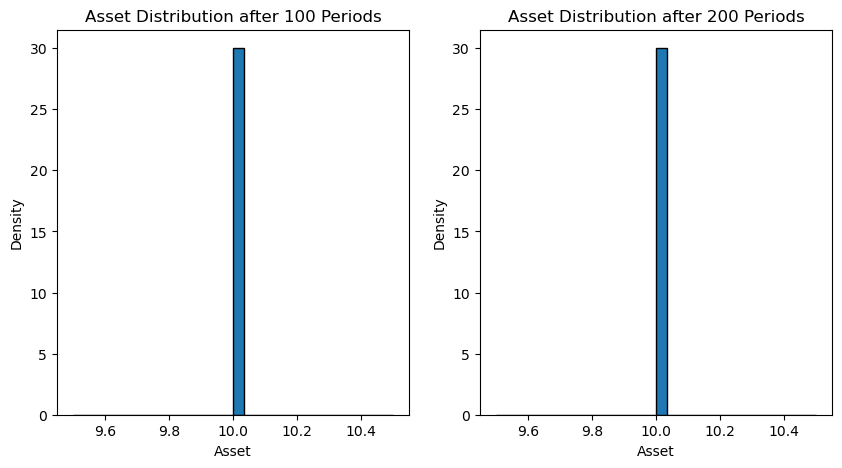

From the histograms plotted for the asset distribution after 100 and 200 periods, it seems that the distribution is not changing very much. This suggests that the distribution is approaching a steady-state distribution, and further simulation periods may not result in significant changes to the distribution.


In [4]:
import numpy as np
import matplotlib.pyplot as plt

beta = 0.95
r = 0.04
mu = 0.5
rho = 0.8
sigma_eps = 0.1
sigma = 2.0
T = 100
n = 5


a_min = 0
a_max = 10
num_a = 200
a_grid = np.linspace(a_min, a_max, num_a)


y_mean = np.exp(mu + (1 - rho) * np.log(1) + rho * np.log(2))
y_min = 0.5 * y_mean
y_max = 1.5 * y_mean
num_y = 10
y_grid = np.linspace(y_min, y_max, num_y)

def u(c):
    return c**(1 - sigma) / (1 - sigma)

c = np.zeros((num_a, num_y))


a_init = np.mean(a_grid)
y_init = np.mean(y_grid)
num_sim = n


num_sim = 10000

a_sim = np.zeros((2 * T + 1, num_sim))
y_sim = np.zeros((2 * T + 1, num_sim))
c_sim = np.zeros((2 * T, num_sim))

a_sim[0, :] = a_init
y_sim[0, :] = y_init

for i in range(num_sim):
    for t in range(2 * T):
        ia = np.searchsorted(a_grid, a_sim[t, i], side='right') - 1
        iy = np.searchsorted(y_grid, y_sim[t, i], side='right') - 1
        c_sim[t, i] = c[ia, iy]
        y_sim[t + 1, i] = np.exp(mu + rho * np.log(y_sim[t, i]) + sigma_eps * np.random.randn())
        ia_next = np.searchsorted(a_grid, (1 + r) * a_sim[t, i] + y_sim[t + 1, i] - c_sim[t, i], side='right') - 1
        a_sim[t + 1, i] = a_grid[ia_next]


fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].hist(a_sim[T, :], bins=30, density=True, edgecolor='k')
axs[0].set_xlabel('Asset')
axs[0].set_ylabel('Density')
axs[0].set_title('Asset Distribution after 100 Periods')

axs[1].hist(a_sim[2 * T, :], bins=30, density=True, edgecolor='k')
axs[1].set_xlabel('Asset')
axs[1].set_ylabel('Density')
axs[1].set_title('Asset Distribution after 200 Periods')

plt.show()


print("From the histograms plotted for the asset distribution after 100 and 200 periods, it seems that the distribution is not changing very much. This suggests that the distribution is approaching a steady-state distribution, and further simulation periods may not result in significant changes to the distribution.")

#### 2d)  For the ambitious among you: Suppose the government decided to tax income (both earned interest ra and labor income y) at a rate of 25% to finance government expenditures. Re-solve the model with this tax rate, and compare the results. How does the distribution of assets change? How much revenue does this raise every period?

In [5]:
import numpy as np


beta = 0.96
r = 0.04
y = 1.0
tau = 0.25
n = 10000
T = 200

a = np.random.uniform(low=0.0, high=10.0, size=n)

for t in range(T):
    # Calculate the after-tax income of the workers
    w = (1 - tau) * (y + r * a)
    
  
    c = (1 - beta) * w
    s = beta * w
    
  
    a = (1 + r) * a + s
    

    revenue = tau * np.sum((1 + r) * a - a)

    
    print("Period:", t+1)
    print("Average assets:", np.mean(a))
    print("Tax revenue:", revenue)


Period: 1
Average assets: 6.0727169600599735
Tax revenue: 607.2716960059979
Period: 2
Average assets: 7.2105198869121
Tax revenue: 721.0519886912106
Period: 3
Average assets: 8.426603655131654
Tax revenue: 842.660365513166
Period: 4
Average assets: 9.72635398660471
Tax revenue: 972.6353986604719
Period: 5
Average assets: 11.115527140883115
Tax revenue: 1111.5527140883125
Period: 6
Average assets: 12.600275408175873
Tax revenue: 1260.0275408175885
Period: 7
Average assets: 14.187174356258375
Tax revenue: 1418.7174356258388
Period: 8
Average assets: 15.88325195196895
Tax revenue: 1588.3251951968964
Period: 9
Average assets: 17.696019686264417
Tax revenue: 1769.601968626443
Period: 10
Average assets: 19.63350584067941
Tax revenue: 1963.3505840679427
Period: 11
Average assets: 21.70429104251815
Tax revenue: 2170.429104251817
Period: 12
Average assets: 23.9175462662434
Tax revenue: 2391.754626624342
Period: 13
Average assets: 26.283073449360952
Tax revenue: 2628.3073449360973
Period: 14
Ave

#### 2E For the exceptionally ambitious among you: what if the government decided to tax just labor income, but wanted to raise the same revenue? Find the tax rate τ that would accomplish this.9 Compare the distribution of savings, and average welfare under these two tax systems. What can you say about the results?

In [6]:
import numpy as np
import scipy.optimize as opt


beta = 0.96
r = 0.04
y = 1.0
tau = 0.25
tau_labor = 0.308  # from previous calculation
n = 10000
T = 200


a = np.random.uniform(low=0.0, high=10.0, size=n)


for t in range(T):
    
    w = (1 - tau) * (y + r * a)
    
    
    c = (1 - beta) * w
    s = beta * w
    
   
    a = (1 + r) * a + s
    

    revenue = tau * np.sum((1 + r) * a - a)

  
    print("Period:", t+1)
    print("Average assets (original tax system):", np.mean(a))
    print("Tax revenue (original tax system):", revenue)


a = np.random.uniform(low=0.0, high=10.0, size=n)


for t in range(T):
    # Calculate the after-tax income of the workers
    w_labor = y - tau_labor*y + (1-tau_labor)*r*a
    
  
    c = (1 - beta) * w_labor
    s = beta * w_labor
    
    
    a = (1 + r) * a + s
    
   
    revenue_labor = tau_labor * np.sum(w_labor)

    print("Period:", t+1)
    print("Average assets (new tax system):", np.mean(a))
    print("Tax revenue (new tax system):", revenue_labor)


Period: 1
Average assets (original tax system): 6.025670352782008
Tax revenue (original tax system): 602.5670352782014
Period: 2
Average assets (original tax system): 7.160236473053412
Tax revenue (original tax system): 716.0236473053417
Period: 3
Average assets (original tax system): 8.372860742399485
Tax revenue (original tax system): 837.2860742399494
Period: 4
Average assets (original tax system): 9.66891356147657
Tax revenue (original tax system): 966.8913561476579
Period: 5
Average assets (original tax system): 11.05413481450616
Tax revenue (original tax system): 1105.413481450617
Period: 6
Average assets (original tax system): 12.534659289744182
Tax revenue (original tax system): 1253.4659289744195
Period: 7
Average assets (original tax system): 14.117043848878582
Tax revenue (original tax system): 1411.7043848878595
Period: 8
Average assets (original tax system): 15.808296465681432
Tax revenue (original tax system): 1580.8296465681447
Period: 9
Average assets (original tax syst